In [1]:
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from utils import load_data
import lifelines
from lifelines.utils import concordance_index
from LFSurv import BinaryClassifier
from utils import R_set, neg_par_log_likelihood, c_index, EarlyStopping

from sklearn.metrics import accuracy_score
dtype = torch.FloatTensor
os.chdir('/cloud-home/U1039935/Autosurv/autobin')
# Define the new model for binary classification
class BinaryClassifier(nn.Module):
    def __init__(self, input_n, level_2_dim, Dropout_Rate_1, Dropout_Rate_2):
        super(BinaryClassifier, self).__init__()
        self.input_n = input_n
        self.level_2_dim = level_2_dim
        self.tanh = nn.Tanh()

        # Binary classification fc layers
        self.bn_input = nn.BatchNorm1d(self.input_n)
        self.fc1 = nn.Linear(self.input_n + 4, self.level_2_dim)
        self.bn2 = nn.BatchNorm1d(self.level_2_dim)
        self.fc2 = nn.Linear(self.level_2_dim, 1)
        
        # Dropout
        self.dropout_1 = nn.Dropout(Dropout_Rate_1)
        self.dropout_2 = nn.Dropout(Dropout_Rate_2)

    def forward(self, latent_features, c1, c2, c3, c4, s_dropout=False):
        if s_dropout:
            latent_features = self.dropout_1(latent_features)
        latent_features = self.bn_input(latent_features)
        clinical_layer = torch.cat((latent_features, c1, c2, c3, c4), 1)
        hidden_layer = self.tanh(self.fc1(clinical_layer))
        if s_dropout:
            hidden_layer = self.dropout_2(hidden_layer)
        hidden_layer = self.bn2(hidden_layer)
        y_pred = torch.sigmoid(self.fc2(hidden_layer))
        
        return y_pred

# def train_binary_classifier(train_x1, train_age, train_stage_i, train_stage_ii, train_race_white, train_yevent,
#                             eval_x1, eval_age, eval_stage_i, eval_stage_ii, eval_race_white, eval_yevent,
#                             input_n, level_2_dim, Dropout_Rate_1, Dropout_Rate_2, Learning_Rate, L2, epoch_num, patience, dtype,
#                             path="saved_model/binary_classifier_checkpoint.pt"):
#     net = BinaryClassifier(input_n, level_2_dim, Dropout_Rate_1, Dropout_Rate_2)

#     early_stopping = EarlyStopping(patience=patience, verbose=False, path=path)

#     if torch.cuda.is_available():
#         net.cuda()
#     opt = optim.Adam(net.parameters(), lr=Learning_Rate, weight_decay=L2)

#     start_time = time.time()
#     for epoch in range(epoch_num):
#         net.train()
#         opt.zero_grad()

#         y_pred = net(train_x1, train_age, train_stage_i, train_stage_ii, train_race_white, s_dropout=True)
#         loss = F.binary_cross_entropy(y_pred.squeeze(), train_yevent.squeeze())

#         loss.backward()
#         opt.step()

#         net.eval()
#         eval_y_pred = net(eval_x1, eval_age, eval_stage_i, eval_stage_ii, eval_race_white, s_dropout=False)
#         eval_accuracy = accuracy_score(eval_yevent.detach().cpu().numpy(), eval_y_pred.detach().cpu().numpy().round())
#         eval_auc = roc_auc_score(eval_yevent.detach().cpu().numpy(), eval_y_pred.detach().cpu().numpy())
#         eval_f1 = f1_score(eval_yevent.detach().cpu().numpy(), eval_y_pred.detach().cpu().numpy().round())

#         early_stopping(eval_accuracy, net)
#         if early_stopping.early_stop:
#             print("Early stopping, number of epochs: ", epoch)
#             print('Save model of Epoch {:d}'.format(early_stopping.best_epoch_num))
#             break
#         if (epoch+1) % 100 == 0:
#             net.eval()
#             train_y_pred = net(train_x1, train_age, train_stage_i, train_stage_ii, train_race_white, s_dropout=False)
#             train_accuracy = accuracy_score(train_yevent.detach().cpu().numpy(), train_y_pred.detach().cpu().numpy().round())
#             print("Training Accuracy: %s," % train_accuracy, "validation Accuracy: %s." % eval_accuracy)

#     print("Loading model, best epoch: %s." % early_stopping.best_epoch_num)
#     net.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

#     net.eval()
#     train_y_pred = net(train_x1, train_age, train_stage_i, train_stage_ii, train_race_white, s_dropout=False)
#     train_accuracy = accuracy_score(train_yevent.detach().cpu().numpy(), train_y_pred.detach().cpu().numpy().round())

#     net.eval()
#     eval_y_pred = net(eval_x1, eval_age, eval_stage_i, eval_stage_ii, eval_race_white, s_dropout=False)
#     eval_accuracy = accuracy_score(eval_yevent.detach().cpu().numpy(), eval_y_pred.detach().cpu().numpy().round())

#     print("Final training Accuracy: %s," % train_accuracy, "final validation Accuracy: %s." % eval_accuracy)
#     time_elapse = np.array(time.time() - start_time).round(2)
#     print("Total time elapse: %s." % time_elapse)

#     return (train_y_pred, eval_y_pred, train_accuracy, eval_accuracy, early_stopping.best_epoch_num)

In [4]:
import time
import torch
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def train_binary_classifier(train_x1, train_age, train_stage_i, train_stage_ii, train_race_white, train_yevent,
                            eval_x1, eval_age, eval_stage_i, eval_stage_ii, eval_race_white, eval_yevent,
                            input_n, level_2_dim, Dropout_Rate_1, Dropout_Rate_2, Learning_Rate, L2, epoch_num, patience, dtype,
                            path="saved_model/binary_classifier_checkpoint.pt", plot = True):
    net = BinaryClassifier(input_n, level_2_dim, Dropout_Rate_1, Dropout_Rate_2)

    early_stopping = EarlyStopping(patience=patience, verbose=False, path=path)

    if torch.cuda.is_available():
        net.cuda()
    opt = optim.Adam(net.parameters(), lr=Learning_Rate, weight_decay=L2)
    
    #calculate the class weight
    pos_weight = (train_yevent.shape[0]-train_yevent.sum())/train_yevent.sum()
    pos_weight = pos_weight.clone().detach().to(dtype=torch.float32)

    start_time = time.time()
    train_losses = []
    val_accuracies = []
    val_aucs = []
    val_f1s = []
    
    for epoch in range(epoch_num):
        net.train()
        opt.zero_grad()

        y_pred = net(train_x1, train_age, train_stage_i, train_stage_ii, train_race_white, s_dropout=True)
        loss = F.binary_cross_entropy_with_logits(y_pred.squeeze(), train_yevent.squeeze(), pos_weight=pos_weight)

        loss.backward()
        opt.step()

        train_losses.append(loss.item())

        net.eval()
        eval_y_pred = net(eval_x1, eval_age, eval_stage_i, eval_stage_ii, eval_race_white, s_dropout=False)
        eval_accuracy = accuracy_score(eval_yevent.detach().cpu().numpy(), eval_y_pred.detach().cpu().numpy().round())
        eval_auc = roc_auc_score(eval_yevent.detach().cpu().numpy(), eval_y_pred.detach().cpu().numpy())
        eval_f1 = f1_score(eval_yevent.detach().cpu().numpy(), eval_y_pred.detach().cpu().numpy().round())
        
        val_accuracies.append(eval_accuracy)
        val_aucs.append(eval_auc)
        val_f1s.append(eval_f1)

        early_stopping(eval_f1, net)
        if early_stopping.early_stop:
            print("Early stopping, number of epochs: ", epoch)
            print('Save model of Epoch {:d}'.format(early_stopping.best_epoch_num))
            break
        if (epoch+1) % 100 == 0:
            net.eval()
            train_y_pred = net(train_x1, train_age, train_stage_i, train_stage_ii, train_race_white, s_dropout=False)
            train_f1 = f1_score(train_yevent.detach().cpu().numpy(), train_y_pred.detach().cpu().numpy().round())
            print("Training F1: %s," % train_f1, "validation F1: %s." % eval_f1)

    print("Loading model, best epoch: %s." % early_stopping.best_epoch_num)
    net.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

    net.eval()
    train_y_pred = net(train_x1, train_age, train_stage_i, train_stage_ii, train_race_white, s_dropout=False)
    train_accuracy = accuracy_score(train_yevent.detach().cpu().numpy(), train_y_pred.detach().cpu().numpy().round())
    train_auc = roc_auc_score(train_yevent.detach().cpu().numpy(), train_y_pred.detach().cpu().numpy())
    train_f1 = f1_score(train_yevent.detach().cpu().numpy(), train_y_pred.detach().cpu().numpy().round())
    
    net.eval()
    eval_y_pred = net(eval_x1, eval_age, eval_stage_i, eval_stage_ii, eval_race_white, s_dropout=False)
    eval_accuracy = accuracy_score(eval_yevent.detach().cpu().numpy(), eval_y_pred.detach().cpu().numpy().round())
    eval_auc = roc_auc_score(eval_yevent.detach().cpu().numpy(), eval_y_pred.detach().cpu().numpy())
    eval_f1 = f1_score(eval_yevent.detach().cpu().numpy(), eval_y_pred.detach().cpu().numpy().round())

    print("Final training Accuracy: %s," % train_accuracy, "final validation Accuracy: %s." % eval_accuracy)
    print("Final training AUC: %s," % train_auc, "final validation AUC: %s." % eval_auc)    
    print("Final training F1: %s," % train_f1, "final validation F1: %s." % eval_f1)
    time_elapse = np.array(time.time() - start_time).round(2)
    print("Total time elapse: %s." % time_elapse)
    if plot == True: 
        # Plotting the metrics
        epochs = range(1, len(train_losses) + 1)
        plt.figure(figsize=(18, 6))

        plt.subplot(1, 4, 1)
        plt.plot(epochs, train_losses, 'b', label='Training loss')
        plt.title('Training loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 4, 2)
        plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
        plt.title('Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 4, 3)
        plt.plot(epochs, val_aucs, 'g', label='Validation AUC')
        plt.plot(epochs, val_f1s, 'm', label='Validation F1')
        plt.title('Validation AUC and F1')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.legend()
        
        plt.subplot(1, 4, 4)
        conf_matrix = confusion_matrix(eval_yevent.detach().cpu().numpy(), eval_y_pred.detach().cpu().numpy().round())
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted label')
        plt.ylabel('True Label')

        plt.tight_layout()
        plt.show()
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(eval_yevent.detach().cpu().numpy(), torch.sigmoid(eval_y_pred).detach().cpu().numpy())
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    

    return (train_y_pred, eval_y_pred, train_accuracy, eval_accuracy, train_auc, eval_auc, train_f1, eval_f1, early_stopping.best_epoch_num)


In [ ]:
start_time = time.time()

# Example of calling the function with your data (assuming the data loading and preprocessing steps are similar)
input_n = 16
level_2_dim = [8, 16, 32]
epoch_num = 500
patience = 200
Initial_Learning_Rate = [0.05, 0.01, 0.0075, 0.005, 0.0025]
L2_Lambda = [0.001, 0.00075, 0.0005, 0.00025, 0.0001]
Dropout_rate_1 = [0.1, 0.3, 0.5]
Dropout_rate_2 = [0.1, 0.3, 0.5]

best_epoch_num = 0

patient_id_train, x_train, ytime_train, yevent_train, age_train, stage_i_train, stage_ii_train, race_white_train = load_data("tune_tr_z_2omics.csv", dtype)
patient_id_valid, x_valid, ytime_valid, yevent_valid, age_valid, stage_i_valid, stage_ii_valid, race_white_valid = load_data("tune_val_z_2omics.csv", dtype)

patient_id_train_overall, x_train_overall, ytime_train_overall, yevent_train_overall, age_train_overall, stage_i_train_overall, stage_ii_train_overall, race_white_train_overall = load_data("tr_z_2omics.csv", dtype)
patient_id_test_overall, x_test_overall, ytime_test_overall, yevent_test_overall, age_test_overall, stage_i_test_overall, stage_ii_test_overall, race_white_test_overall = load_data("tes_z_2omics.csv", dtype)
opt_l2 = 0
opt_lr = 0
opt_dim = 0
opt_dr1 = 0
opt_dr2 = 0

opt_va = float(0)
opt_tr = float(0)
for l2 in L2_Lambda:
    for lr in Initial_Learning_Rate:
        for dim in level_2_dim:
            for dr1 in Dropout_rate_1:
                for dr2 in Dropout_rate_2:
                    _, _, accuracy_train, accuracy_valid, train_auc, eval_auc, train_f1, eval_f1, best_epoch_num_tune = train_binary_classifier(x_train, age_train, stage_i_train, stage_ii_train, race_white_train, yevent_train,
                                                                                                        x_valid, age_valid, stage_i_valid, stage_ii_valid, race_white_valid, yevent_valid,
                                                                                                        input_n, dim, dr1, dr2, lr, l2, epoch_num, patience, dtype,
                                                                                                        path="saved_models/binary_classifier_checkpoint_tune.pt", plot = False)

                    if eval_f1 > opt_va:
                        opt_l2 = l2
                        opt_lr = lr
                        opt_dim = dim
                        opt_dr1 = dr1
                        opt_dr2 = dr2
                        opt_tr = train_f1
                        opt_va = eval_f1
                        best_epoch_num = best_epoch_num_tune
                    print("L2: %s," % l2, "LR: %s." % lr, "dim: %s," % dim, "dr1: %s," % dr1, "dr2: %s." % dr2)
                    print("Training F1: %s," % train_f1, "validation F1: %s." % eval_f1)

train_y_pred, test_y_pred, accuracy_train, accuracy_test, train_auc, test_auc, train_f1, test_f1, best_epoch_num_overall = train_binary_classifier(x_train_overall, age_train_overall, stage_i_train_overall, stage_ii_train_overall, race_white_train_overall, yevent_train_overall,
                                                                                                           x_test_overall, age_test_overall, stage_i_test_overall, stage_ii_test_overall, race_white_test_overall, yevent_test_overall,
                                                                                                           input_n, opt_dim, opt_dr1, opt_dr2, opt_lr, opt_l2, epoch_num, patience, dtype,
                                                                                                           path="saved_models/binary_classifier_checkpoint_overall.pt")
print("Optimal L2: %s," % opt_l2, "optimal LR: %s," % opt_lr, "optimal dim: %s," % opt_dim, "optimal dr1: %s," % opt_dr1, "optimal dr2: %s," % opt_dr2, "best epoch number in tuning: %s." % best_epoch_num)
print("Optimal training f1: %s," % opt_va, "optimal validation F1: %s." % opt_tr)
print("Testing phase: training Accuracy: %s," % accuracy_train, "testing Accuracy: %s." % accuracy_test)
print("Testing phase: training AUC: %s," % train_auc, "testing AUC: %s." % test_auc)
print("Testing phase: training F1: %s," % train_f1, "testing F1: %s." % test_f1)
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))

EarlyStopping counter: 20 out of 200
Training F1: 0.3448275862068966, validation F1: 0.2222222222222222.
EarlyStopping counter: 20 out of 200
EarlyStopping counter: 40 out of 200
EarlyStopping counter: 60 out of 200
EarlyStopping counter: 20 out of 200
Training F1: 0.3684210526315789, validation F1: 0.20833333333333334.
EarlyStopping counter: 20 out of 200
EarlyStopping counter: 40 out of 200
EarlyStopping counter: 60 out of 200
EarlyStopping counter: 80 out of 200
EarlyStopping counter: 100 out of 200
Training F1: 0.4444444444444444, validation F1: 0.29508196721311475.
EarlyStopping counter: 120 out of 200
EarlyStopping counter: 140 out of 200
EarlyStopping counter: 160 out of 200
EarlyStopping counter: 180 out of 200
EarlyStopping counter: 20 out of 200
Training F1: 0.4066390041493776, validation F1: 0.35443037974683544.
EarlyStopping counter: 40 out of 200
EarlyStopping counter: 60 out of 200
EarlyStopping counter: 80 out of 200
EarlyStopping counter: 100 out of 200
EarlyStopping co

In [ ]:
print("--- %s seconds ---" % (end_time - start_time))

In [ ]:
#25-30 mins

EarlyStopping counter: 20 out of 200
Training F1: 0.3828125, validation F1: 0.4155844155844156.
EarlyStopping counter: 20 out of 200
EarlyStopping counter: 40 out of 200
EarlyStopping counter: 60 out of 200
EarlyStopping counter: 80 out of 200
EarlyStopping counter: 100 out of 200
Training F1: 0.3465346534653465, validation F1: 0.26229508196721313.
EarlyStopping counter: 120 out of 200
EarlyStopping counter: 140 out of 200
EarlyStopping counter: 160 out of 200
EarlyStopping counter: 180 out of 200
EarlyStopping counter: 200 out of 200
Early stopping, number of epochs:  294
Save model of Epoch 95
Loading model, best epoch: 95.
Final training Accuracy: 0.6697782963827305, final validation Accuracy: 0.7213930348258707.
Final training AUC: 0.696476125596086, final validation AUC: 0.7236280487804878.
Final training F1: 0.3668903803131991, final validation F1: 0.5.
Total time elapse: 2.74.


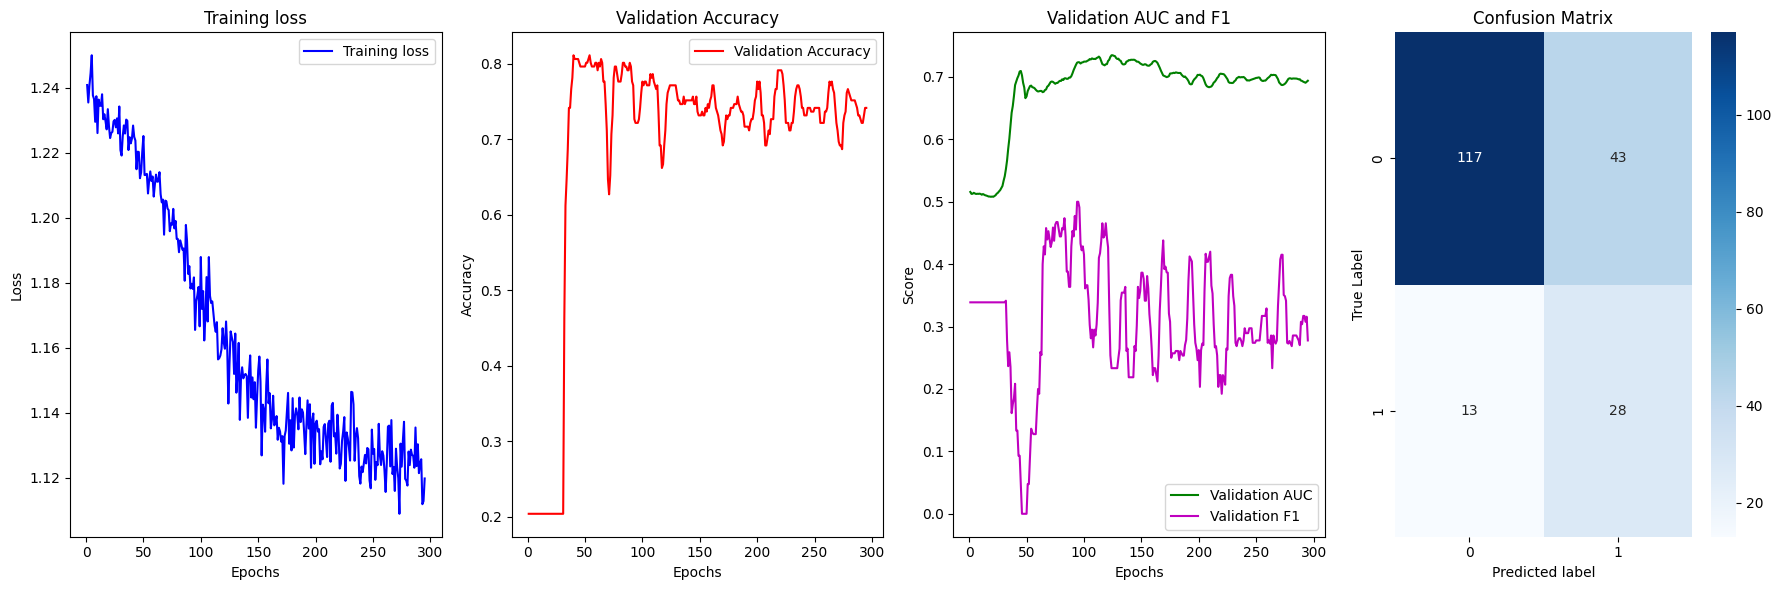

Optimal L2: 0.001, optimal LR: 0.0025, optimal dim: 8, optimal dr1: 0.5, optimal dr2: 0.5, best epoch number in tuning: 106.
Optimal training f1: 0.5057471264367817, optimal validation F1: 0.391025641025641.
Testing phase: training Accuracy: 0.6697782963827305, testing Accuracy: 0.7213930348258707.
Testing phase: training AUC: 0.696476125596086, testing AUC: 0.7236280487804878.
Testing phase: training F1: 0.3668903803131991, testing F1: 0.5.
--- 7237.846090555191 seconds ---


In [7]:

train_y_pred, test_y_pred, accuracy_train, accuracy_test, train_auc, test_auc, train_f1, test_f1, best_epoch_num_overall = train_binary_classifier(x_train_overall, age_train_overall, stage_i_train_overall, stage_ii_train_overall, race_white_train_overall, yevent_train_overall,
                                                                                                           x_test_overall, age_test_overall, stage_i_test_overall, stage_ii_test_overall, race_white_test_overall, yevent_test_overall,
                                                                                                           input_n, opt_dim, opt_dr1, opt_dr2, opt_lr, opt_l2, epoch_num, patience, dtype,
                                                                                                           path="saved_models/binary_classifier_checkpoint_overall.pt")
print("Optimal L2: %s," % opt_l2, "optimal LR: %s," % opt_lr, "optimal dim: %s," % opt_dim, "optimal dr1: %s," % opt_dr1, "optimal dr2: %s," % opt_dr2, "best epoch number in tuning: %s." % best_epoch_num)
print("Optimal training f1: %s," % opt_va, "optimal validation F1: %s." % opt_tr)
print("Testing phase: training Accuracy: %s," % accuracy_train, "testing Accuracy: %s." % accuracy_test)
print("Testing phase: training AUC: %s," % train_auc, "testing AUC: %s." % test_auc)
print("Testing phase: training F1: %s," % train_f1, "testing F1: %s." % test_f1)
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))